In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)

In [4]:
%matplotlib notebook

In [6]:
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'

experiment = 'gratings'
trial_epoch = 'plushalf'
responsive_test='nstds'
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                if not meta.query('@va == visual_area and @dk == datakey').empty])
# Neural data
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 

traces001|dff_responsive-nstds-thr10.00
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


In [7]:
import _pickle as pkl
import analyze2p.decoding as dec

In [8]:
analysis_type='by_fov'
test_type = None
trial_epoch = 'plushalf'
test_str = 'default' if test_type is None else test_type

C_value=1.0
test_split=0.2
cv_nfolds=5

In [9]:
dk = '20190616_JC097_fov1'
va = 'V1'
sdf = aggr.get_stimuli(dk, experiment)

In [10]:
chance_level = 1/8. if experiment=='gratings' else 0.5

class_name='morphlevel' if experiment=='blobs' else 'ori'
if experiment=='gratings':
    variation_name = None
else:
    variation_name = None if test_type is None else 'size'
variation_values=None
class_a = 0 if class_name=='morphlevel' else None
class_b = 106 if class_name=='morphlevel' else None
print(class_name, class_a, class_b)
class_values = [class_a, class_b] if class_name=='morphlevel' \
            else sdf[class_name].unique()

clf_params={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True,
            'return_clf': False,
            'verbose': False}

ori None None


In [11]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [35]:
break_correlations=False

def aggregate_iterated_results(experiment, meta, traceid='traces001',
                      trial_epoch='plushalf', responsive_test='nstds', 
                      C_value=1., break_correlations=False, 
                      overlap_thr=None):
    iterdf=None
    missing_=[]
    d_list=[]
    for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
        results_id = dec.create_results_id(C_value=C_value, 
                                       visual_area=va,
                                       trial_epoch=trial_epoch,
                                       responsive_test=responsive_test,
                                       break_correlations=break_correlations,
                                       overlap_thr=None)
        # results_id = '__'.join(tmp_id.split('__')[0:-1])
        try:
            session, animalid, fovn = hutils.split_datakey_str(dk)
            results_dir = glob.glob(os.path.join(rootdir, animalid, session, 
                                  'FOV%i_*' % fovn,
                                  'combined_%s_*' % experiment, 'traces/%s*' % traceid, 
                                  'decoding_test', test_str))[0]
            results_fpath = os.path.join(results_dir, '%s.pkl' % results_id)
            assert os.path.exists(results_fpath)
        except Exception as e:
            missing_.append((va, dk))
            continue
        with open(results_fpath, 'rb') as f:
            res = pkl.load(f)
        d_list.append(res)
    if len(d_list)>0:
        iterdf = pd.concat(d_list)
    
    return iterdf, missing_

In [57]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [73]:
C_value=1.
overlap_thr=None
trial_epoch='plushalf'

iterdf, missing_ = aggregate_iterated_results(experiment, meta, traceid=traceid,
                      trial_epoch=trial_epoch, responsive_test=responsive_test, 
                      C_value=C_value, break_correlations=False, 
                      overlap_thr=overlap_thr)

iterdf_b, missing_ = aggregate_iterated_results(experiment, meta, traceid=traceid,
                      trial_epoch=trial_epoch, responsive_test=responsive_test, 
                      C_value=C_value, break_correlations=True, 
                      overlap_thr=overlap_thr)

In [74]:
iterdf.shape, iterdf_b.shape

((6600, 16), (6600, 16))

In [75]:
df_intact = iterdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
df_intact['intact'] = True
df_nocc = iterdf_b.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()
df_nocc['intact'] = False

In [76]:
DF = pd.concat([df_intact, df_nocc], axis=0)


<IPython.core.display.Javascript object>


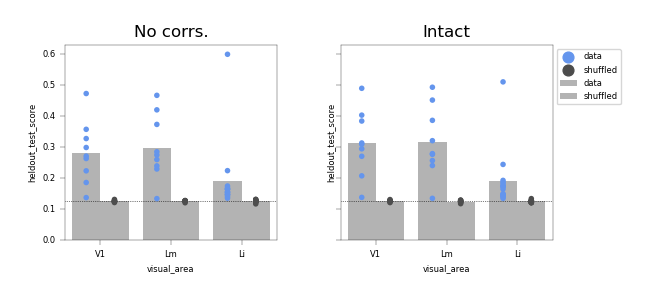

In [77]:
bw_cond_colors = dict((k, [0.7]*3) for k in ['data', 'shuffled'])
cond_colors = {'data': 'cornflowerblue', 'shuffled': [0.3]*3}


fig, axn = pl.subplots(1,2, figsize=(6.5, 3), sharex=True, sharey=True)
for ai, (is_intact, df) in enumerate(DF.groupby('intact')):
    ax=axn[ai]
    corr_str = 'Intact' if is_intact else 'No corrs.'
    ax.set_title(corr_str)
    sns.barplot(x='visual_area', y=metric, data=df, ax=ax,
            hue='condition', order=visual_areas, ci=None, palette=bw_cond_colors)
    sns.stripplot(x='visual_area', y=metric, data=df, ax=ax,
            hue='condition', order=visual_areas, palette=cond_colors,
            jitter=False, dodge=True, s=4)
    
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.85,
                  wspace=0.3)

<IPython.core.display.Javascript object>


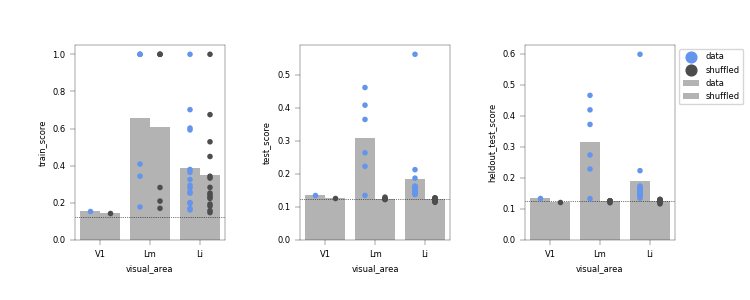

In [44]:
bw_cond_colors = dict((k, [0.7]*3) for k in ['data', 'shuffled'])
cond_colors = {'data': 'cornflowerblue', 'shuffled': [0.3]*3}

metric_list = ['train_score', 'test_score', 'heldout_test_score']

fig, axn = pl.subplots(1, len(metric_list), figsize=(2.5*len(metric_list), 3))
for ai, metric in enumerate(metric_list):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=df, ax=ax,
            hue='condition', order=visual_areas, ci=None, palette=bw_cond_colors)
    sns.stripplot(x='visual_area', y=metric, data=df, ax=ax,
            hue='condition', order=visual_areas, palette=cond_colors,
            jitter=False, dodge=True, s=4)
    
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.85,
                  wspace=0.5)

In [86]:
1/8.

0.125

# Example FOV

In [513]:
print(experiment)
dk = '20191006_JC110_fov1'
va = 'V1'

nmetrics = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)].copy()

gratings


In [514]:
# stimuli
sdf = aggr.get_stimuli(dk, experiment)
# zscore data
ndf_z = aggr.get_zscored_from_ndf(nmetrics)
n_cells = int(ndf_z.shape[1]-1) 
print("... BY_FOV [%s] %s, n=%i cells" % (va, dk, n_cells))

... BY_FOV [V1] 20191006_JC110_fov1, n=93 cells


In [523]:
import copy
inargs = copy.copy(clf_params)


In [524]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [525]:
inum=3
test_type=None
i_df = dec.select_test(inum, test_type, ndf_z, sdf, **inargs)
i_df

... 3 - selecting


,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,n_cells,n_trials,iteration
3,0.472028,0.010411,0.255849,0.835691,0.289775,0.094974,0.418057,0.304688,1.0,606,data,93,1280,3
3,1.024186,0.010827,0.127958,0.648679,0.079508,-0.012930,0.114706,0.136719,1.0,606,shuffled,93,1280,3


In [509]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [538]:
neuraldf = ndf_z.copy()
tvals = neuraldf.index.tolist()
neuraldf.loc[neuraldf.index, 'trial'] = tvals         


In [526]:
res = dec.fit_svm_mp(ndf_z, sdf, None, n_iterations=10, n_processes=1,
              **clf_params)

... 0 - selecting
--> Elapsed time: 12.50sec
... 1 - selecting
--> Elapsed time: 12.42sec
... 2 - selecting
--> Elapsed time: 12.68sec
... 3 - selecting
--> Elapsed time: 11.49sec
... 4 - selecting
--> Elapsed time: 13.12sec
... 5 - selecting
--> Elapsed time: 12.25sec
... 6 - selecting
--> Elapsed time: 12.25sec
... 7 - selecting
--> Elapsed time: 11.91sec
... 8 - selecting
--> Elapsed time: 11.87sec
... 9 - selecting
--> Elapsed time: 12.10sec


In [533]:
res[['train_score', 'test_score', 'heldout_test_score', 'condition']].groupby(['condition']).describe()

train_score                                                    \
                count      mean       std       min       25%       50%   
condition                                                                 
data             10.0  0.840819  0.010435  0.827876  0.831909  0.839475   
shuffled         10.0  0.616845  0.010824  0.597910  0.614318  0.617431   

                              test_score            ...                      \
                75%       max      count      mean  ...       75%       max   
condition                                           ...                       
data       0.848389  0.859373       10.0  0.258572  ...  0.265328  0.275371   
shuffled   0.621334  0.634036       10.0  0.124227  ...  0.133576  0.138661   

          heldout_test_score                                                   \
                       count      mean       std      min       25%       50%   
condition                                                                       
data                    10.0  0.273828  0.030002  0.21875  0.254883  0.275391   
shuffled                10.0  0.129688  0.023567  0.09375  0.110352  0.136719   

                               
                75%       max  
condition                      
data       0.294922  0.320312  
shuffled   0.146484  0.160156  

[2 rows x 24 columns]

In [365]:
inum =2
res = dec.do_fit_within_fov(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_a=class_a, class_b=class_b, 
                     do_shuffle=True, balance_configs=True, return_clf=False)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:1182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_trial_col = True


In [376]:
# inum =2
# res = dec.train_test_size

In [436]:
inum =2
class_name='morphlevel'
class_values = [0, 106]
variation_name='size'
variation_values = sorted(sdf[variation_name].unique())

res = dec.train_test_size_subset(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_values=class_values,
                     variation_name=variation_name,
                     variation_values=variation_values,
                     n_train_configs=4,
                     do_shuffle=True, balance_configs=True, return_clf=False)


In [437]:
res

,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells
0,0.006387,0.000969,0.706091,1.0,0.040743,0.045418,0.058780,0.641509,1.0,7228,data,10_20_30_40,10_20_30_40,264,False,2,221
1,0.008795,0.001038,0.492802,1.0,0.022424,0.019121,0.032351,0.396226,1.0,7228,shuffled,10_20_30_40,10_20_30_40,264,False,2,221
2,0.006387,0.000969,0.706091,1.0,0.084611,0.119522,0.122068,0.686567,1.0,7228,data,10_20_30_40,50.0,67,True,2,221
3,0.006277,0.000910,0.663677,1.0,0.102707,0.137532,0.148175,0.716981,1.0,9823,data,10_20_30_50,10_20_30_50,264,False,2,221
4,0.007357,0.000959,0.502436,1.0,0.000147,-0.014046,0.000213,0.490566,1.0,9823,shuffled,10_20_30_50,10_20_30_50,264,False,2,221
5,0.006277,0.000910,0.663677,1.0,0.111929,0.152264,0.161479,0.731343,1.0,9823,data,10_20_30_50,40.0,67,True,2,221
6,0.005600,0.000857,0.682835,1.0,0.001548,-0.011960,0.002234,0.528302,1.0,5767,data,10_20_40_50,10_20_40_50,264,False,2,221
7,0.008921,0.001029,0.426135,1.0,0.004288,-0.008155,0.006187,0.547170,1.0,5767,shuffled,10_20_40_50,10_20_40_50,264,False,2,221
8,0.005600,0.000857,0.682835,1.0,0.046699,0.058313,0.067372,0.647059,1.0,5767,data,10_20_40_50,30.0,68,True,2,221
9,0.005312,0.000805,0.668217,1.0,0.052276,0.062297,0.075418,0.660377,1.0,1688,data,10_30_40_50,10_30_40_50,264,False,2,221


In [430]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [431]:
inum =2
class_name='morphlevel'
class_values = [0, 106]
variation_name='size'
variation_values = sorted(sdf[variation_name].unique())

res = dec.train_test_size_single(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_values=class_values,
                     variation_name=variation_name,
                     variation_values=variation_values,
                     n_train_configs=4,
                     do_shuffle=True, balance_configs=True, return_clf=False)


1.0
(4,)
1.0
(4,)
0.610909090909091
(4,)
0.0020420074462890623
(4,)
0.0006659507751464843
(4,)
6564
(4,)
10.0
(4,)
1.0
(4,)
1.0
(4,)
0.7654545454545454
(4,)
0.0014920711517333984
(4,)
0.0004935741424560546
(4,)
5899
(4,)
20.0
(4,)
1.0
(4,)
1.0
(4,)
0.7781818181818183
(4,)
0.0015712738037109374
(4,)
0.0005093574523925781
(4,)
6167
(4,)
30.0
(4,)
1.0
(4,)
1.0
(4,)
0.730909090909091
(4,)
0.0014906883239746093
(4,)
0.0005062580108642578
(4,)
1901
(4,)
40.0
(4,)
1.0
(4,)
1.0
(4,)
0.6581818181818182
(4,)
0.0014026165008544922
(4,)
0.00045900344848632814
(4,)
1571
(4,)
50.0
(4,)


In [434]:
res.groupby(['condition', 'novel']).mean()

fit_time  score_time  test_score  train_score  heldout_MI  \
condition novel                                                              
data      False  0.001600    0.000527    0.708727          1.0    0.311854   
          True   0.001600    0.000527    0.708727          1.0    0.066433   
shuffled  False  0.001566    0.000512    0.535636          1.0    0.044120   

                 heldout_aMI  heldout_log2MI  heldout_test_score    C   randi  \
condition novel                                                                 
data      False     0.418541        0.449911            0.828571  1.0  4420.4   
          True      0.087560        0.095842            0.615979  1.0  4420.4   
shuffled  False     0.004287        0.063652            0.385714  1.0  4420.4   

                 train_transform  test_transform  n_trials  iteration  n_cells  
condition novel                                                                 
data      False             30.0            30.0      66.8        2.0    221.0  
          True              30.0            30.0      67.4        2.0    221.0  
shuffled  False             30.0            30.0      66.8        2.0    221.0

In [435]:
res

,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,train_transform,test_transform,n_trials,novel,iteration,n_cells
0,0.002042,0.000666,0.610909,1.0,0.051757,0.014048,0.074670,0.642857,1.0,6564,data,10.0,10.0,68,False,2,221
1,0.001622,0.000542,0.536364,1.0,0.010239,-0.045851,0.014772,0.428571,1.0,6564,shuffled,10.0,10.0,68,False,2,221
2,0.002042,0.000666,0.610909,1.0,0.001906,-0.009494,0.002749,0.522388,1.0,6564,data,10.0,20.0,67,True,2,221
3,0.002042,0.000666,0.610909,1.0,0.004072,-0.005124,0.005874,0.455882,1.0,6564,data,10.0,30.0,68,True,2,221
4,0.002042,0.000666,0.610909,1.0,0.015436,0.012156,0.022270,0.417910,1.0,6564,data,10.0,40.0,67,True,2,221
5,0.002042,0.000666,0.610909,1.0,0.011254,0.005980,0.016236,0.447761,1.0,6564,data,10.0,50.0,67,True,2,221
6,0.001492,0.000494,0.765455,1.0,0.178715,0.213523,0.257831,0.785714,1.0,5899,data,20.0,20.0,66,False,2,221
7,0.001532,0.000509,0.536364,1.0,0.094878,0.083770,0.136879,0.285714,1.0,5899,shuffled,20.0,20.0,66,False,2,221
8,0.001492,0.000494,0.765455,1.0,0.000000,-0.010967,0.000000,0.500000,1.0,5899,data,20.0,10.0,68,True,2,221
9,0.001492,0.000494,0.765455,1.0,0.148230,0.205488,0.213851,0.764706,1.0,5899,data,20.0,30.0,68,True,2,221


In [323]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn import preprocessing
import sklearn.svm as svm
import sklearn.metrics as skmetrics

In [324]:
curr_data = ndf_z.copy()

In [325]:
#train_configs = sdf.index.tolist() 
train_configs = sdf[sdf[class_name].isin(classes)].index.tolist()

In [326]:
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data = aggr.equal_counts_df(sample_data)
sample_data

cell,0,5,7,18,19,23,28,29,31,32,...,269,281,288,301,302,312,313,320,328,config
trial,,,,,,,,,,,,,,,,,,,,,
1,0.078445,3.518986,2.386371,2.065101,1.772836,2.844329,6.966225,2.896976,0.653192,10.089535,...,-0.164878,8.258746,2.634527,2.821428,2.481068,0.051350,4.542824,2.827181,3.383868,config026
2,-1.152818,2.411491,-1.177954,-1.545042,-0.570205,-1.209613,-2.667617,1.343814,0.083505,4.195097,...,0.485428,2.386171,0.460740,-1.567966,0.821425,2.398091,0.324374,0.870920,1.180770,config010
3,0.653396,-0.478914,1.738281,0.001385,0.050060,0.559490,0.375340,-0.152469,-0.746372,-2.348391,...,-1.453632,-0.395428,-1.813270,-0.891581,-0.165115,-0.872763,-0.717911,-1.029094,-0.618699,config064
4,0.185509,3.109562,1.258647,1.130251,3.139119,2.926035,1.981328,2.537235,3.525917,3.392522,...,0.600094,3.968396,-2.109809,3.060546,2.697869,1.365633,1.174444,-0.252590,-0.690846,config049
5,0.078475,0.641078,-0.774927,0.050371,0.160926,0.657146,1.224734,-0.247175,-0.125525,-0.307120,...,-0.120079,-0.518387,1.194934,0.557252,-0.521050,-1.567678,-0.070270,-0.935974,-1.906833,config016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,-0.908171,-1.047119,-0.665546,-0.792583,-0.189404,-0.488754,-0.217741,0.785077,-1.084245,-0.527047,...,1.143603,-0.249548,0.400215,-1.178330,-0.037441,-0.708547,-0.409609,-1.561999,1.337479,config036
1277,-0.950673,0.268023,-0.629667,-0.320041,-0.581986,-0.839074,-0.043377,0.029160,0.095245,0.118334,...,-0.134356,-0.735776,-0.139399,-0.779681,0.012811,-0.048304,-0.166939,0.786257,-0.632552,config020
1278,0.689772,-0.785139,-0.222806,-0.573672,-0.244134,0.766249,-0.241643,-0.316434,-0.208946,0.138407,...,0.189678,0.926258,1.687781,0.384967,0.557723,0.457051,0.216065,-0.821144,-0.463522,config046


In [367]:
test = sample_data.drop('config', 1)
test.shape, sample_data.shape


((1280, 93), (1280, 94))

In [371]:
(test.values - zdata.values).max()


0.0

In [347]:
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = sdf.loc[targets['config'].values][class_name].astype(int).values

In [348]:
rois_ = [r for r in sample_data.columns if hutils.isnumber(r)]
zdata= sample_data[rois_].copy()
len(rois_), zdata.shape

(93, (1280, 93))

In [352]:
randi=100
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'randi': randi,
            'return_clf': False,
            'verbose': False}

In [353]:
citer = dec.fit_svm(zdata, targets, **clf_params)

In [354]:
citer

{'fit_time': 0.4293060779571533,
 'score_time': 0.009502601623535157,
 'test_score': 0.2627116212338594,
 'train_score': 0.8334923612972392,
 'heldout_MI': 0.25045956622441773,
 'heldout_aMI': 0.07479709081582958,
 'heldout_log2MI': 0.3613367741351682,
 'heldout_test_score': 0.25390625,
 'C': 1.0,
 'randi': 100}

In [329]:

train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                            targets['label'].values,
                                                            test_size=test_split,
                                                            stratify=targets['label'],
                                                            shuffle=True,
                                                            random_state=randi)


In [330]:
pd.DataFrame(train_labels).value_counts()

0      128
45     128
90     128
135    128
180    128
225    128
270    128
315    128
dtype: int64

In [331]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
svc_ = svm.SVC(kernel='linear', C=C_value, random_state=randi,
              decision_function_shape='ovr')

In [332]:
scores = cross_validate(svc_, train_data, train_labels, cv=5,
                        scoring=('accuracy'), 
                        return_train_score=True)
scores


{'fit_time': array([0.47146988, 0.47107625, 0.38281775, 0.44801259, 0.41353726]),
 'score_time': array([0.01139474, 0.00999784, 0.00940156, 0.00930309, 0.00928378]),
 'test_score': array([0.28780488, 0.27317073, 0.25853659, 0.21463415, 0.27941176]),
 'train_score': array([0.84249084, 0.83394383, 0.81929182, 0.82295482, 0.84878049])}

In [333]:
trained_svc = svc_.fit(train_data, train_labels)

In [334]:
test_data = scaler.transform(test_data)
test_score = trained_svc.score(test_data, test_labels)
predicted_labels = trained_svc.predict(test_data)


<IPython.core.display.Javascript object>


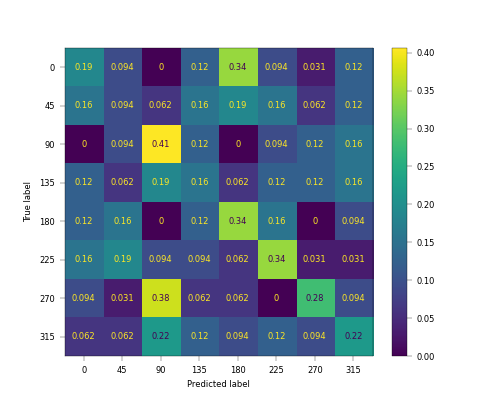

In [341]:
skmetrics.plot_confusion_matrix(trained_svc, test_data, test_labels, 
                                normalize='true')  

In [11]:
def wraper_func(func, **kwargs):
    output = func(**kwargs)
    return output

In [20]:
def func1(x='Func1', y='Alt1', z='Extra1'):
    res = '%s_%s_%s' % (x, y, z)
    return res

def func2(x='Func2', y='Alt2', w='Extra2'):
    res = '%s_%s_%s' % (x, y, z)
    r2 = 'andthis'
    return res, r2

In [23]:
inargs = {'x': 'check1', 'z': 'check2'}
inargs = (x='check1', y='check2')
res = wraper_func(func1, **inargs)
res

SyntaxError: invalid syntax (<ipython-input-23-0a6f99e4a23c>, line 2)

In [22]:
res = wraper_func(func2, **inargs)
res

TypeError: func2() got an unexpected keyword argument 'z'

In [ ]:
decode_from_fov(dk, va, neuraldf, sdf, C_value=C_value,
                        n_iterations=n_iterations, n_processes=n_processes, results_id=results_id,
                        class_a=class_a, class_b=class_b, do_shuffle=do_shuffle,
                        rootdir=rootdir, verbose=verbose,
                        test_type=test_type, n_train_configs=n_train_configs) 
            print("--- done by_fov ---")